# Frequency Bias Experiments

Main repository for experiment. Select a dataset, architecture and model weight and it will estimate the frequency bands and perform MDA, producing a bar graph of the result

In [2]:
%load_ext autoreload
%autoreload 2
import datasets
import utils
import numpy as np
import hyperopt as hp
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as kr

In [3]:
# magic
tf.keras.backend.set_floatx('float32')
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

### Available options

In [4]:
datasets.show_available(datasets.AVAILABLE_TESTS)

Available datasets: RestrictedImageNet


In [16]:
# Choose 
DATASET_NAME = "RestrictedImageNet"
MODEL_NAME = "2020-09-01_RestrictedImageNet_VGG16"
PERCENT = 0.1 # we suggest 0.2 for CIFAR10 and 0.1 for everything else
BATCH_SIZE = 16

### Load Dataset and define bands

In [17]:
# Choose Dataset - check which ones are available
dataset = datasets.get_test_dataset(DATASET_NAME, datasets.default_datagen, BATCH_SIZE)

Found 10150 images belonging to 9 classes.


### Define Frequency Bands
Remember our theoretical energy distribution:

$\mathbb{E}[\text{energy[i, j]}] = \frac{A}{||(i, j)||_1^{\alpha}}$

We will adjust $A$ and $\alpha$ for this dataset using hyperopt to match the empirical distribution (represented here as the average energy per band on the test dataset)


In [7]:
# Version for full dataset in memory
#dataset_shape = X_test.shape[1], X_test.shape[2]
#emp_dist = utils.get_mean_energy_dataset(X_test)

In [18]:
# Version for generators
emp_dist = utils.get_mean_energy_iterator(dataset.test_datagen)

<ipython-input-19-900d04066420>:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(emp_dist), cmap="hot")


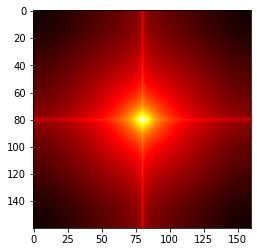

In [19]:
plt.imshow(np.log(emp_dist), cmap="hot")

Text(0.5, 1.0, 'Energy Distribution (CIFAR10)')

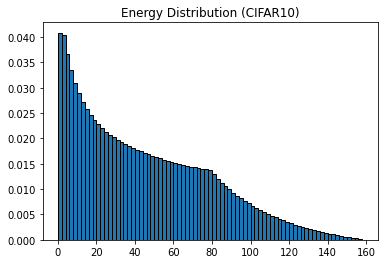

In [20]:
steps = np.arange(0, dataset.input_shape[1], 2)
height, width = utils.get_energy_histogram(emp_dist, steps)
plt.bar(steps[:-1], height, width, edgecolor="black", align="edge")
plt.title("Energy Distribution (CIFAR10)")

Text(0.5, 1.0, 'Energy Distribution (Restricted ImageNet)')

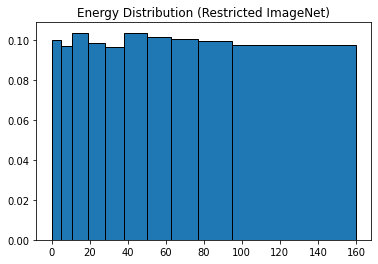

In [30]:
percent_range = utils.get_percentage_masks_relevance(emp_dist, PERCENT)
height, width = utils.get_energy_histogram(emp_dist, percent_range)
plt.bar(percent_range[0:-1], height, width, edgecolor="black", align="edge")
plt.title("Energy Distribution (Restricted ImageNet)")

### Load Model and Weights

In [13]:
mod = kr.models.load_model("model_weights/" + MODEL_NAME)

#### Calculate Baseline

In [23]:
baseline_acc = utils.get_accuracy_iterator(mod, dataset.test_datagen)

In [24]:
baseline_acc

0.6409852216748768

In [25]:
removed_acc = []
for i in range(len(percent_range) - 1):
    preproc = lambda Xfr: utils.remove_frequency_ring_dataset(Xfr, percent_range[i], percent_range[i + 1])
    removed_acc.append(utils.get_accuracy_iterator(mod, dataset.test_datagen, preproc=preproc))

<BarContainer object of 10 artists>

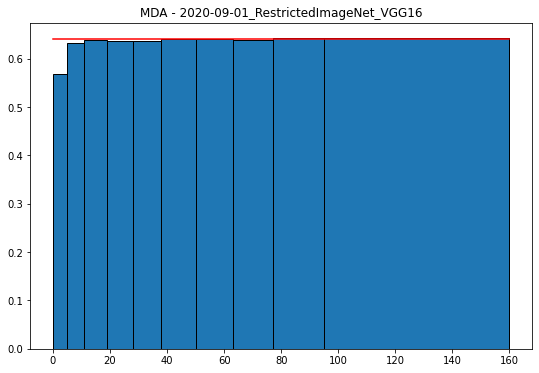

In [32]:
plt.figure(figsize=(9, 6))
plt.title("MDA - " + MODEL_NAME)
plt.plot(percent_range, [baseline_acc] * len(percent_range), color="red")
plt.bar(percent_range[0:-1], removed_acc, width, edgecolor="black", align="edge")
#plt.savefig("MDA_" + MODEL_NAME + ".png")

# Appendix

### Optional: visualize dataset images

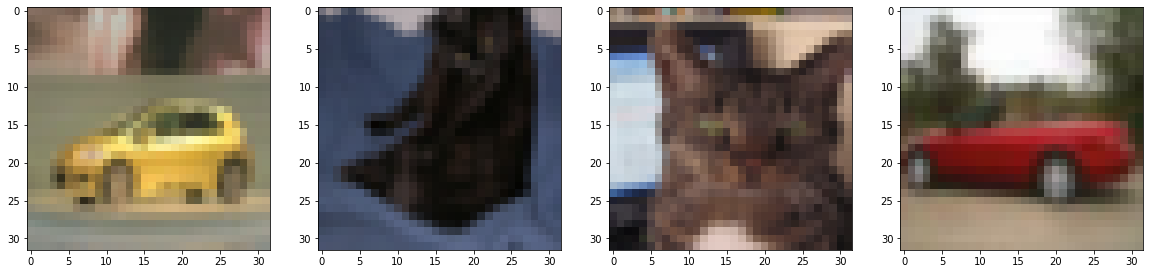

In [45]:
chosen = np.random.choice(np.arange(X_test.shape[0]), 4, replace=False)
Xchosen = X_test[chosen]

plt.figure(figsize=(20, 6))
plt.subplot(1, 4, 1)
plt.imshow(Xchosen[0])
plt.subplot(1, 4, 2)
plt.imshow(Xchosen[1])
plt.subplot(1, 4, 3)
plt.imshow(Xchosen[2])
plt.subplot(1, 4, 4)
plt.imshow(Xchosen[3])

### Optional: visualize images filtered

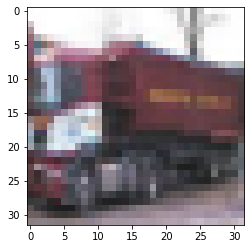

In [260]:
# assuming X_test, emp_dist and percent_range already calculated
chosen = np.random.choice(np.arange(X_test.shape[0]))
Xchosen = X_test[chosen]
_ = plt.imshow(Xchosen)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


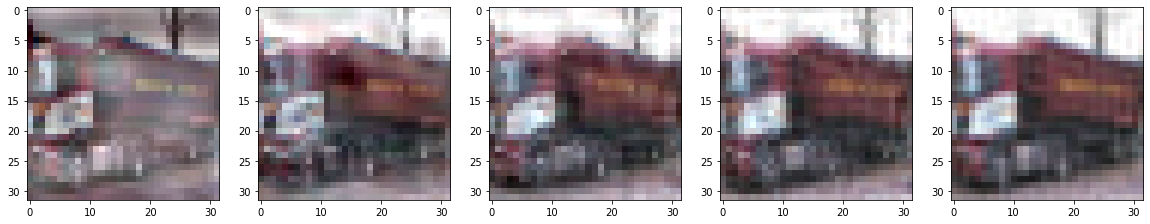

In [280]:
plt.figure(figsize=(20, 10))

for i in range(len(percent_range) - 1):
    nowchosen = utils.remove_frequency_ring(Xchosen, percent_range[i], percent_range[i + 1])
    plt.subplot(1 + int(len(percent_range) > 6), 5, i + 1)
    plt.imshow(nowchosen)